In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from imblearn.over_sampling import SMOTE
from catboost import CatBoostClassifier
from lime.lime_tabular import LimeTabularExplainer
from scipy.stats import uniform, randint  # Import randint and uniform
import pickle
import warnings

# Suppress warnings
warnings.filterwarnings("ignore")

In [52]:
import pandas as pd

# Load dataset
df = pd.read_csv('../data/PCOS_data.csv')

# Basic check
print("Shape:", df.shape)
df.head()


Shape: (541, 45)


,Sl. No,Patient File No.,PCOS (Y/N),Age (yrs),Weight (Kg),Height(Cm),BMI,Blood Group,Pulse rate(bpm),RR (breaths/min),...,Fast food (Y/N),Reg.Exercise(Y/N),BP _Systolic (mmHg),BP _Diastolic (mmHg),Follicle No. (L),Follicle No. (R),Avg. F size (L) (mm),Avg. F size (R) (mm),Endometrium (mm),Unnamed: 44
0,1,1,0,28,44.6,152.0,19.3,15,78,22,...,1.0,0,110,80,3,3,18.0,18.0,8.5,NaN
1,2,2,0,36,65.0,161.5,24.9,15,74,20,...,0.0,0,120,70,3,5,15.0,14.0,3.7,NaN
2,3,3,1,33,68.8,165.0,25.3,11,72,18,...,1.0,0,120,80,13,15,18.0,20.0,10.0,NaN
3,4,4,0,37,65.0,148.0,29.7,13,72,20,...,0.0,0,120,70,2,2,15.0,14.0,7.5,NaN
4,5,5,0,25,52.0,161.0,20.1,11,72,18,...,0.0,0,120,80,3,4,16.0,14.0,7.0,NaN


In [53]:
import pandas as pd

# Load the dataset
df = pd.read_csv('../data/PCOS_data.csv')

# Check the first few rows of the dataset
df.head()

# Check for missing values and data types
df.info()

# Check the distribution of the target variable
df['PCOS (Y/N)'].value_counts()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 45 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Sl. No                  541 non-null    int64  
 1   Patient File No.        541 non-null    int64  
 2   PCOS (Y/N)              541 non-null    int64  
 3    Age (yrs)              541 non-null    int64  
 4   Weight (Kg)             541 non-null    float64
 5   Height(Cm)              541 non-null    float64
 6   BMI                     541 non-null    float64
 7   Blood Group             541 non-null    int64  
 8   Pulse rate(bpm)         541 non-null    int64  
 9   RR (breaths/min)        541 non-null    int64  
 10  Hb(g/dl)                541 non-null    float64
 11  Cycle(R/I)              541 non-null    int64  
 12  Cycle length(days)      541 non-null    int64  
 13  Marraige Status (Yrs)   540 non-null    float64
 14  Pregnant(Y/N)           541 non-null    in

PCOS (Y/N)
0    364
1    177
Name: count, dtype: int64

In [54]:
print(df.shape)

(541, 45)


In [55]:
# Check for duplicates and nulls
print(df.duplicated().sum())
print(df.isnull().sum())
print(df.dtypes)


0
Sl. No                      0
Patient File No.            0
PCOS (Y/N)                  0
 Age (yrs)                  0
Weight (Kg)                 0
Height(Cm)                  0
BMI                         0
Blood Group                 0
Pulse rate(bpm)             0
RR (breaths/min)            0
Hb(g/dl)                    0
Cycle(R/I)                  0
Cycle length(days)          0
Marraige Status (Yrs)       1
Pregnant(Y/N)               0
No. of abortions            0
  I   beta-HCG(mIU/mL)      0
II    beta-HCG(mIU/mL)      0
FSH(mIU/mL)                 0
LH(mIU/mL)                  0
FSH/LH                      0
Hip(inch)                   0
Waist(inch)                 0
Waist:Hip Ratio             0
TSH (mIU/L)                 0
AMH(ng/mL)                  0
PRL(ng/mL)                  0
Vit D3 (ng/mL)              0
PRG(ng/mL)                  0
RBS(mg/dl)                  0
Weight gain(Y/N)            0
hair growth(Y/N)            0
Skin darkening (Y/N)        0
Hair los

In [56]:
df.drop(['Sl. No', 'Patient File No.'], axis=1, inplace=True, errors='ignore')

# Also drop unnamed columns or those with only 1 unique value
df = df.loc[:, df.nunique() > 1]
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]


In [57]:
df.columns = df.columns.str.strip().str.replace(' ', '_').str.replace('[^A-Za-z0-9_]', '', regex=True)


In [58]:
# Encode binary Y/N columns
binary_cols = df.select_dtypes(include='object').columns
for col in binary_cols:
    df[col] = df[col].map({'Y': 1, 'N': 0})


In [59]:
# Convert columns that should be numeric
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='ignore')  # will leave object cols unchanged


In [60]:
# Replace 0s in specific health-related features if it makes sense medically
df.replace(0, pd.NA, inplace=True)

# Fill numeric with median
df.fillna(df.median(numeric_only=True), inplace=True)


In [61]:
print(df.columns.tolist())


['PCOS_YN', 'Age_yrs', 'Weight_Kg', 'HeightCm', 'BMI', 'Blood_Group', 'Pulse_ratebpm', 'RR_breathsmin', 'Hbgdl', 'CycleRI', 'Cycle_lengthdays', 'Marraige_Status_Yrs', 'PregnantYN', 'No_of_abortions', 'I___betaHCGmIUmL', 'II____betaHCGmIUmL', 'FSHmIUmL', 'LHmIUmL', 'FSHLH', 'Hipinch', 'Waistinch', 'WaistHip_Ratio', 'TSH_mIUL', 'AMHngmL', 'PRLngmL', 'Vit_D3_ngmL', 'PRGngmL', 'RBSmgdl', 'Weight_gainYN', 'hair_growthYN', 'Skin_darkening_YN', 'Hair_lossYN', 'PimplesYN', 'Fast_food_YN', 'RegExerciseYN', 'BP__Systolic_mmHg', 'BP__Diastolic_mmHg', 'Follicle_No_L', 'Follicle_No_R', 'Avg_F_size_L_mm', 'Avg_F_size_R_mm', 'Endometrium_mm']


In [62]:
print(df.shape)

(541, 42)


In [63]:
df = pd.read_csv('../data/PCOS_data.csv')

# Standardize columns
df.columns = (
    df.columns
    .str.strip()
    .str.replace(' ', '_')
    .str.replace(r'[^\w]', '', regex=True)
)

# Confirm the target column
print(df.columns.tolist())  # Look for 'PCOS_YN' or similar

# Confirm class distribution
print(df['PCOS_YN'].value_counts())


['Sl_No', 'Patient_File_No', 'PCOS_YN', 'Age_yrs', 'Weight_Kg', 'HeightCm', 'BMI', 'Blood_Group', 'Pulse_ratebpm', 'RR_breathsmin', 'Hbgdl', 'CycleRI', 'Cycle_lengthdays', 'Marraige_Status_Yrs', 'PregnantYN', 'No_of_abortions', 'I___betaHCGmIUmL', 'II____betaHCGmIUmL', 'FSHmIUmL', 'LHmIUmL', 'FSHLH', 'Hipinch', 'Waistinch', 'WaistHip_Ratio', 'TSH_mIUL', 'AMHngmL', 'PRLngmL', 'Vit_D3_ngmL', 'PRGngmL', 'RBSmgdl', 'Weight_gainYN', 'hair_growthYN', 'Skin_darkening_YN', 'Hair_lossYN', 'PimplesYN', 'Fast_food_YN', 'RegExerciseYN', 'BP__Systolic_mmHg', 'BP__Diastolic_mmHg', 'Follicle_No_L', 'Follicle_No_R', 'Avg_F_size_L_mm', 'Avg_F_size_R_mm', 'Endometrium_mm', 'Unnamed_44']
PCOS_YN
0    364
1    177
Name: count, dtype: int64


In [64]:
print(df.columns.tolist())


['Sl_No', 'Patient_File_No', 'PCOS_YN', 'Age_yrs', 'Weight_Kg', 'HeightCm', 'BMI', 'Blood_Group', 'Pulse_ratebpm', 'RR_breathsmin', 'Hbgdl', 'CycleRI', 'Cycle_lengthdays', 'Marraige_Status_Yrs', 'PregnantYN', 'No_of_abortions', 'I___betaHCGmIUmL', 'II____betaHCGmIUmL', 'FSHmIUmL', 'LHmIUmL', 'FSHLH', 'Hipinch', 'Waistinch', 'WaistHip_Ratio', 'TSH_mIUL', 'AMHngmL', 'PRLngmL', 'Vit_D3_ngmL', 'PRGngmL', 'RBSmgdl', 'Weight_gainYN', 'hair_growthYN', 'Skin_darkening_YN', 'Hair_lossYN', 'PimplesYN', 'Fast_food_YN', 'RegExerciseYN', 'BP__Systolic_mmHg', 'BP__Diastolic_mmHg', 'Follicle_No_L', 'Follicle_No_R', 'Avg_F_size_L_mm', 'Avg_F_size_R_mm', 'Endometrium_mm', 'Unnamed_44']


In [65]:
df['II____betaHCGmIUmL'] = pd.to_numeric(df['II____betaHCGmIUmL'], errors='coerce')
df = df.drop(columns=['Sl_No', 'Patient_File_No', 'Unnamed_44'], errors='ignore')

for col in df.columns:
    if col != 'PCOS_YN':
        df[col] = pd.to_numeric(df[col], errors='coerce')  # will set 'a' or bad entries to NaN


In [66]:
df.fillna(df.median(numeric_only=True), inplace=True)


In [67]:
yn_cols = ['PregnantYN', 'Weight_gainYN', 'hair_growthYN', 'Skin_darkening_YN',
           'Hair_lossYN', 'PimplesYN', 'Fast_food_YN', 'RegExerciseYN']
df[yn_cols] = df[yn_cols].replace({'Y': 1, 'N': 0})


In [68]:
num_cols = df.select_dtypes(include=['float64', 'int64']).columns.drop('PCOS_YN')
df[num_cols] = df[num_cols].replace(0, np.nan)  # if 0 means missing
df[num_cols] = df[num_cols].fillna(df[num_cols].median())


In [69]:
print(df['PCOS_YN'].value_counts(normalize=True))


PCOS_YN
0    0.672828
1    0.327172
Name: proportion, dtype: float64


In [70]:
X = df.drop('PCOS_YN', axis=1)
y = df['PCOS_YN']


In [71]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


In [75]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

# Optional: check class balance after SMOTE
from collections import Counter
print("After SMOTE:", Counter(y_train_resampled))


After SMOTE: Counter({0: 291, 1: 291})


In [72]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [73]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [74]:
print(df.columns.tolist())


['PCOS_YN', 'Age_yrs', 'Weight_Kg', 'HeightCm', 'BMI', 'Blood_Group', 'Pulse_ratebpm', 'RR_breathsmin', 'Hbgdl', 'CycleRI', 'Cycle_lengthdays', 'Marraige_Status_Yrs', 'PregnantYN', 'No_of_abortions', 'I___betaHCGmIUmL', 'II____betaHCGmIUmL', 'FSHmIUmL', 'LHmIUmL', 'FSHLH', 'Hipinch', 'Waistinch', 'WaistHip_Ratio', 'TSH_mIUL', 'AMHngmL', 'PRLngmL', 'Vit_D3_ngmL', 'PRGngmL', 'RBSmgdl', 'Weight_gainYN', 'hair_growthYN', 'Skin_darkening_YN', 'Hair_lossYN', 'PimplesYN', 'Fast_food_YN', 'RegExerciseYN', 'BP__Systolic_mmHg', 'BP__Diastolic_mmHg', 'Follicle_No_L', 'Follicle_No_R', 'Avg_F_size_L_mm', 'Avg_F_size_R_mm', 'Endometrium_mm']


In [76]:
from catboost import CatBoostClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, accuracy_score
from scipy.stats import uniform, randint

# Initialize CatBoost (no need to specify too many params here)
base_model = CatBoostClassifier(
    loss_function='Logloss',
    verbose=0,
    random_state=42
)

# Define hyperparameter space
param_dist = {
    'iterations': randint(100, 700),
    'depth': randint(4, 12),
    'learning_rate': uniform(0.01, 0.1),
    'l2_leaf_reg': randint(1, 10),
    'border_count': randint(32, 255)
}

# Randomized search
random_search = RandomizedSearchCV(
    estimator=base_model,
    param_distributions=param_dist,
    n_iter=50,  #  increase this for a more exhaustive search
    cv=3,
    verbose=2,
    scoring='f1',
    n_jobs=-1
)

# Fit
random_search.fit(X_train_resampled, y_train_resampled)

# Best model
best_model = random_search.best_estimator_
print("Best parameters:", random_search.best_params_)

# Predict
y_pred = best_model.predict(X_test_scaled)
y_proba = best_model.predict_proba(X_test_scaled)[:, 1]

# Evaluation
print(classification_report(y_test, y_pred))
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best parameters: {'border_count': 80, 'depth': 10, 'iterations': 171, 'l2_leaf_reg': 5, 'learning_rate': np.float64(0.04898982872184127)}
              precision    recall  f1-score   support

           0       0.91      0.88      0.90        73
           1       0.77      0.83      0.80        36

    accuracy                           0.86       109
   macro avg       0.84      0.86      0.85       109
weighted avg       0.87      0.86      0.86       109

Accuracy: 0.8623853211009175


In [77]:
# Check the column names in the dataset
print(df.columns)


Index(['PCOS_YN', 'Age_yrs', 'Weight_Kg', 'HeightCm', 'BMI', 'Blood_Group',
       'Pulse_ratebpm', 'RR_breathsmin', 'Hbgdl', 'CycleRI',
       'Cycle_lengthdays', 'Marraige_Status_Yrs', 'PregnantYN',
       'No_of_abortions', 'I___betaHCGmIUmL', 'II____betaHCGmIUmL', 'FSHmIUmL',
       'LHmIUmL', 'FSHLH', 'Hipinch', 'Waistinch', 'WaistHip_Ratio',
       'TSH_mIUL', 'AMHngmL', 'PRLngmL', 'Vit_D3_ngmL', 'PRGngmL', 'RBSmgdl',
       'Weight_gainYN', 'hair_growthYN', 'Skin_darkening_YN', 'Hair_lossYN',
       'PimplesYN', 'Fast_food_YN', 'RegExerciseYN', 'BP__Systolic_mmHg',
       'BP__Diastolic_mmHg', 'Follicle_No_L', 'Follicle_No_R',
       'Avg_F_size_L_mm', 'Avg_F_size_R_mm', 'Endometrium_mm'],
      dtype='object')


In [78]:
binary_cols = ['PregnantYN', 'Weight_gainYN', 'hair_growthYN', 'Skin_darkening_YN',
               'Hair_lossYN', 'PimplesYN', 'Fast_food_YN', 'RegExerciseYN']
df[binary_cols] = df[binary_cols].replace({'Y': 1, 'N': 0})
df = df.dropna(axis=1, how='all')  # drops columns with all NaNs
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


In [ ]:
##Drop this code
#from sklearn.impute import SimpleImputer
#from sklearn.preprocessing import StandardScaler
#from imblearn.over_sampling import SMOTE
#from sklearn.naive_bayes import GaussianNB
#from sklearn.metrics import accuracy_score

# 1. Impute missing values in X_train and X_test
imputer = SimpleImputer(strategy='median')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# 2. Apply SMOTE on imputed data (before scaling)
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_imputed, y_train)

# 3. Now scale both train and test
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test_imputed)

# 4. Train Gaussian Naive Bayes
gnb = GaussianNB()
gnb.fit(X_train_scaled, y_train_resampled)

# 5. Predict and evaluate
y_pred = gnb.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(classification_report(y_test, y_pred))
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(f" GNB Accuracy: {accuracy:.4f}")


              precision    recall  f1-score   support

           0       0.91      0.55      0.68        73
           1       0.49      0.89      0.63        36

    accuracy                           0.66       109
   macro avg       0.70      0.72      0.66       109
weighted avg       0.77      0.66      0.67       109

Accuracy: 0.6605504587155964
 GNB Accuracy: 0.6606



Random Forest Results:
              precision    recall  f1-score   support

           0       0.92      0.89      0.90        73
           1       0.79      0.83      0.81        36

    accuracy                           0.87       109
   macro avg       0.85      0.86      0.86       109
weighted avg       0.87      0.87      0.87       109

Confusion Matrix:
 [[65  8]
 [ 6 30]]
Accuracy: 0.8716


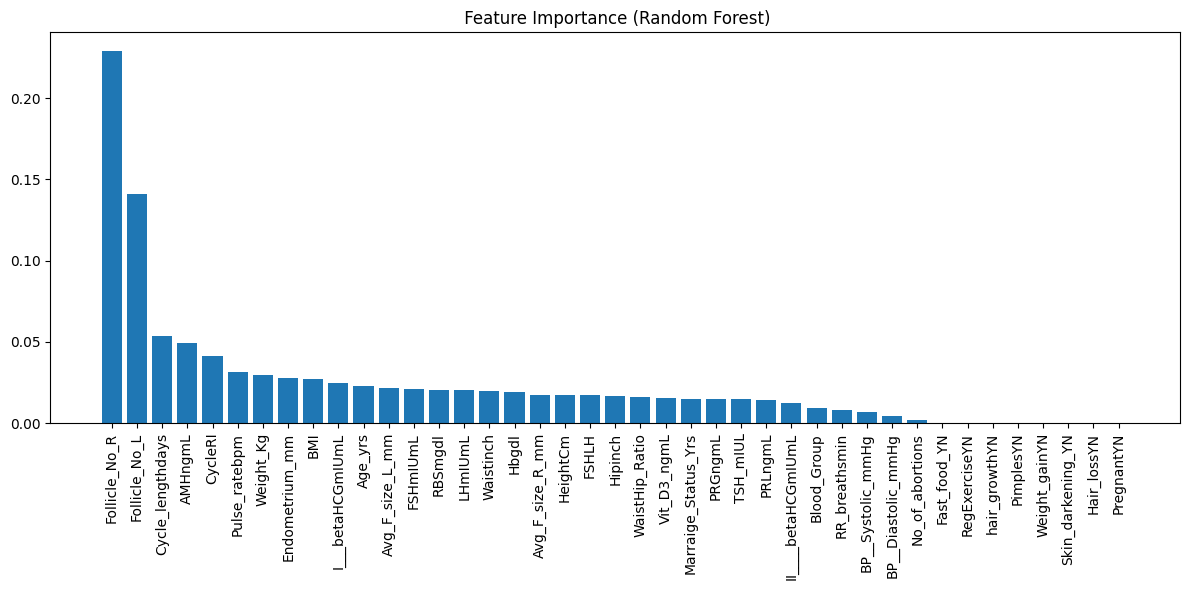

In [80]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt

# ---------- STEP 1: Split ----------
X = df.drop('PCOS_YN', axis=1)
y = df['PCOS_YN']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# ---------- STEP 2: Imputation ----------
# Handle missing values (including binary/categorical Y/N features)
imputer = SimpleImputer(strategy='median')
X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train), columns=X.columns)
X_test_imputed = pd.DataFrame(imputer.transform(X_test), columns=X.columns)

# ---------- STEP 3: Scaling ----------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

# ---------- STEP 4: SMOTE ----------
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

# ---------- STEP 5: Random Forest Training ----------
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    class_weight='balanced',
    random_state=42
)
rf.fit(X_train_resampled, y_train_resampled)

# ---------- STEP 6: Evaluation ----------
y_pred_rf = rf.predict(X_test_scaled)

print("\nRandom Forest Results:")
print(classification_report(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("Accuracy: {:.4f}".format(accuracy_score(y_test, y_pred_rf)))

# ---------- STEP 7: Feature Importance ----------
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = X.columns

plt.figure(figsize=(12, 6))
plt.title(" Feature Importance (Random Forest)")
plt.bar(range(len(importances)), importances[indices], align='center')
plt.xticks(range(len(importances)), np.array(feature_names)[indices], rotation=90)
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import classification_report, accuracy_score

# Re-wrap CatBoost in a scikit-learn compatible form if needed
from catboost import CatBoostClassifier

catboost_model = CatBoostClassifier(
    iterations=141,
    depth=8,
    learning_rate=0.0533,
    l2_leaf_reg=9,
    border_count=72,
    loss_function='Logloss',
    verbose=0
)
catboost_model.fit(X_train_resampled, y_train_resampled)

# Random Forest
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=12,
    random_state=42
)
rf_model.fit(X_train_resampled, y_train_resampled)

# Create Voting Ensemble
ensemble_model = VotingClassifier(
    estimators=[
        ('catboost', catboost_model),
        ('random_forest', rf_model)
    ],
    voting='soft',
    weights=[2, 1]  # Optional: prioritize CatBoost more
)

# Fit Ensemble
ensemble_model.fit(X_train_resampled, y_train_resampled)

# Predict
y_pred_ensemble = ensemble_model.predict(X_test_scaled)

# Evaluation
print(" Ensemble (CatBoost + RF) Results:")
print(classification_report(y_test, y_pred_ensemble))
print(f'Ensemble Accuracy: {accuracy_score(y_test, y_pred_ensemble):.4f}')


 Ensemble (CatBoost + RF) Results:
              precision    recall  f1-score   support

           0       0.91      0.88      0.90        73
           1       0.77      0.83      0.80        36

    accuracy                           0.86       109
   macro avg       0.84      0.86      0.85       109
weighted avg       0.87      0.86      0.86       109

Ensemble Accuracy: 0.8624


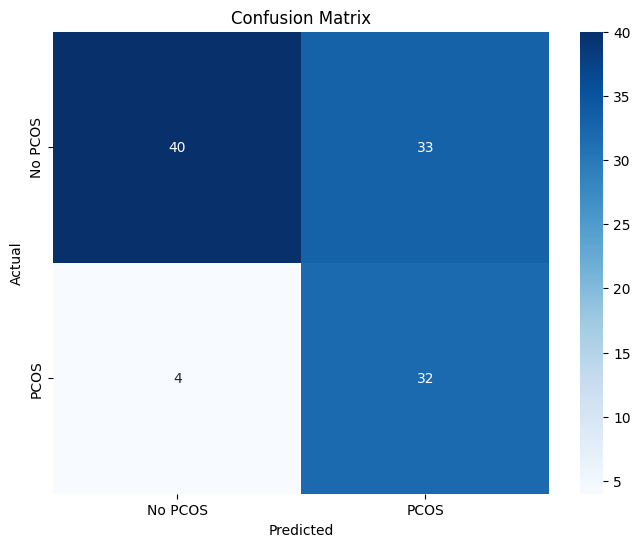

In [82]:
#Confusion Matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No PCOS', 'PCOS'], yticklabels=['No PCOS', 'PCOS'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


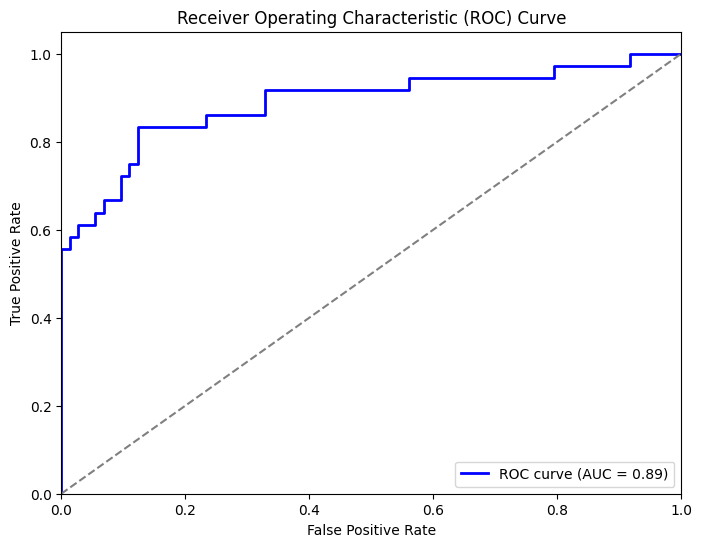

In [83]:
#ROC Curve & AUC
from sklearn.metrics import roc_curve, auc

# Get false positive rate, true positive rate and thresholds
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


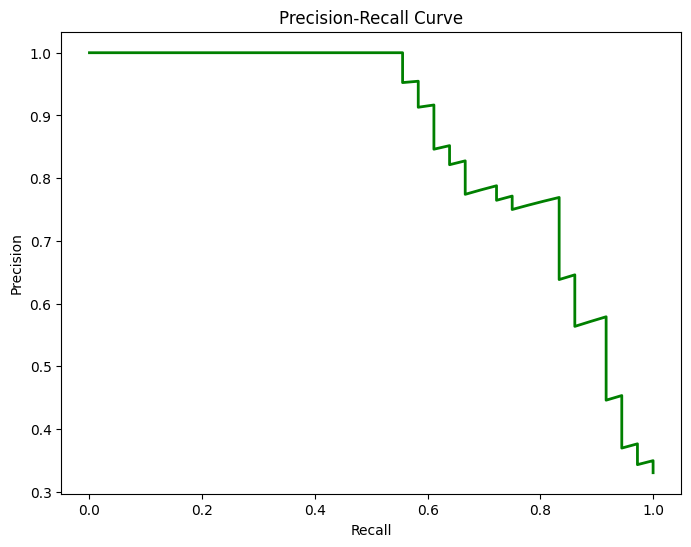

In [84]:
#Precision-Recall Curve
from sklearn.metrics import precision_recall_curve

# Get precision, recall, and thresholds
precision, recall, _ = precision_recall_curve(y_test, y_proba)

# Plot precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='green', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()


In [85]:
#Feature Importance (for CatBoost)
# Plot feature importance from CatBoost
import pandas as pd

# Get the feature importances
importances = model.get_feature_importance()

# Create a DataFrame of feature importances
feature_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
})

# Sort the features by importance
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Plot the top 10 most important features
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importances.head(10))
plt.title('Top 10 Feature Importances (CatBoost)')
plt.show()


NameError: name 'model' is not defined

In [ ]:
import pandas as pd

# Get feature importances from the CatBoost model
importances = model.get_feature_importance()

# Create a DataFrame to hold feature names and their corresponding importance
feature_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
})

# Sort the features by importance
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Display the feature importance table
print(feature_importances)

# Optionally, save to a CSV for later use
feature_importances.to_csv('catboost_feature_importances.csv', index=False)


NameError: name 'model' is not defined

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix
correlation_matrix = df.corr()

# Display the correlation matrix
print(correlation_matrix)

# Optional: Display the correlation with the target variable (PCOS_YN)
print("\nCorrelation with PCOS_YN:")
print(correlation_matrix['PCOS_YN'].sort_values(ascending=False))


                      PCOS_YN   Age_yrs  Weight_Kg  HeightCm       BMI  \
PCOS_YN              1.000000 -0.168513   0.211938  0.068254  0.199697   
Age_yrs             -0.168513  1.000000  -0.029734 -0.119819  0.021372   
Weight_Kg            0.211938 -0.029734   1.000000  0.420098  0.901688   
HeightCm             0.068254 -0.119819   0.420098  1.000000 -0.006845   
BMI                  0.199697  0.021372   0.901688 -0.006845  1.000000   
Blood_Group          0.036433 -0.010954   0.072682  0.040825  0.061328   
Pulse_ratebpm        0.091821  0.045831   0.019983 -0.074339  0.050507   
RR_breathsmin        0.036928  0.087382   0.043614 -0.029459  0.061579   
Hbgdl                0.087170 -0.021558   0.009594  0.024378  0.003832   
CycleRI              0.401644 -0.085943   0.200758 -0.017336  0.232703   
Cycle_lengthdays    -0.184692  0.043251   0.005834  0.024718 -0.005132   
Marraige_Status_Yrs -0.115209  0.664256   0.041879 -0.070002  0.082964   
PregnantYN                NaN       Na

PCOS_YN
0    0.672828
1    0.327172
Name: proportion, dtype: float64


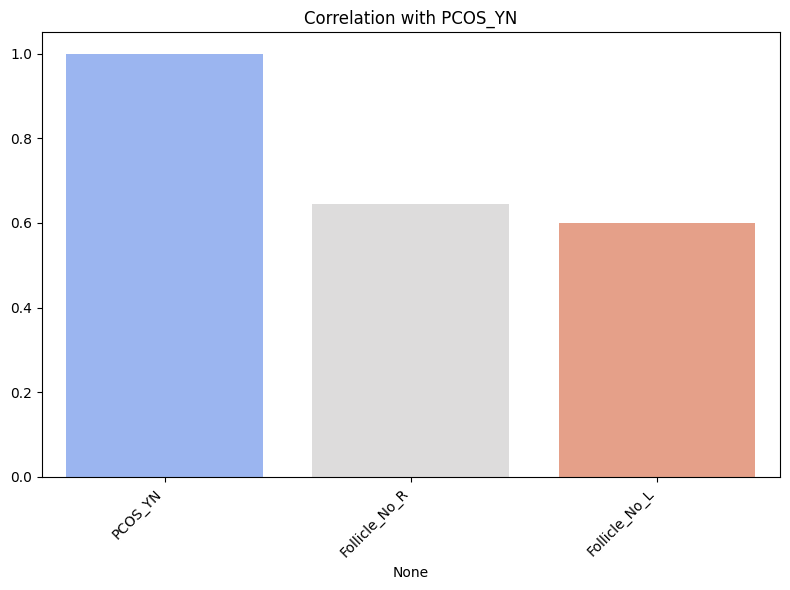

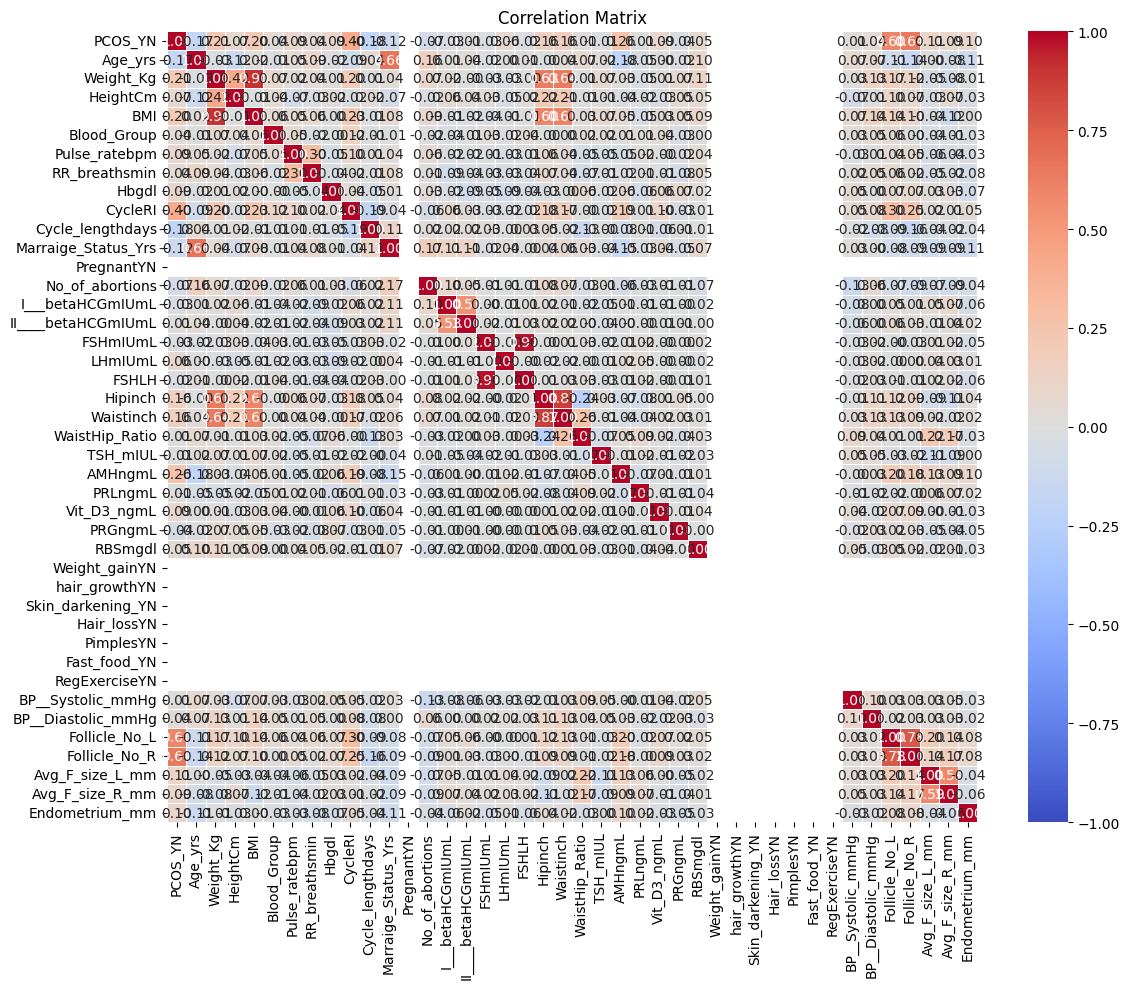

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('../data/PCOS_data.csv')

# Standardize column names
df.columns = (
    df.columns
    .str.strip()
    .str.replace(' ', '_')
    .str.replace(r'[^\w]', '', regex=True)
)

# Fill missing values and handle categorical columns
df['II____betaHCGmIUmL'] = pd.to_numeric(df['II____betaHCGmIUmL'], errors='coerce')
df = df.drop(columns=['Sl_No', 'Patient_File_No', 'Unnamed_44'], errors='ignore')

for col in df.columns:
    if col != 'PCOS_YN':
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Fill missing values with median
df.fillna(df.median(numeric_only=True), inplace=True)

# Replace categorical 'Y'/'N' columns with 1/0
yn_cols = ['PregnantYN', 'Weight_gainYN', 'hair_growthYN', 'Skin_darkening_YN',
           'Hair_lossYN', 'PimplesYN', 'Fast_food_YN', 'RegExerciseYN']
df[yn_cols] = df[yn_cols].replace({'Y': 1, 'N': 0})

# Handle numeric columns, replace zeros with NaN and fill with median
num_cols = df.select_dtypes(include=['float64', 'int64']).columns.drop('PCOS_YN')
df[num_cols] = df[num_cols].replace(0, np.nan)
df[num_cols] = df[num_cols].fillna(df[num_cols].median())

# Check target class distribution
print(df['PCOS_YN'].value_counts(normalize=True))

# Correlation analysis
corr_matrix = df.corr()

# Filter to show only significant correlations (threshold can be adjusted)
threshold = 0.5
filtered_correlation = corr_matrix['PCOS_YN'].abs().sort_values(ascending=False)
filtered_correlation = filtered_correlation[filtered_correlation > threshold]

# Plot the correlations using a bar plot
plt.figure(figsize=(8, 6))
sns.barplot(x=filtered_correlation.index, y=filtered_correlation.values, palette='coolwarm')
plt.title('Correlation with PCOS_YN')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Optionally, show the full correlation matrix (neat version)
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()


Prediction for class 0 (No PCOS): 0.1220
Prediction for class 1 (PCOS): 0.8780


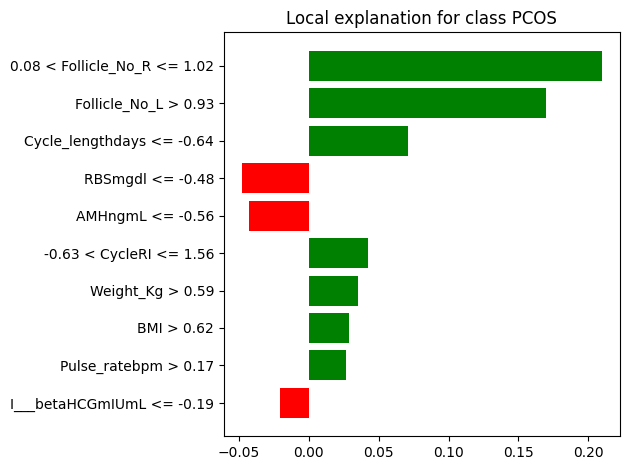

In [ ]:
from lime.lime_tabular import LimeTabularExplainer
import numpy as np
import matplotlib.pyplot as plt

# Create LIME explainer
explainer = LimeTabularExplainer(
    training_data=X_train_resampled,  # The training data
    feature_names=X.columns,  # Feature names (columns of X)
    class_names=['No PCOS', 'PCOS'],  # Class labels for binary classification
    mode='classification',  # Since it's a classification task
    training_labels=y_train_resampled,  # Labels for training data
    discretize_continuous=True  # For discretizing continuous features
)

# Select a random test instance (you can choose any index from the test set)
idx = 12  # Pick an index from the test set for explanation
instance = X_test_scaled[idx]  # Instance to explain

# Get the model prediction (probabilities)
prediction = ensemble_model.predict_proba([instance])[0]
print(f"Prediction for class 0 (No PCOS): {prediction[0]:.4f}")
print(f"Prediction for class 1 (PCOS): {prediction[1]:.4f}")

# Explain the model's prediction for the chosen instance
explanation = explainer.explain_instance(instance, ensemble_model.predict_proba)

# Plot the explanation
fig = explanation.as_pyplot_figure()
plt.tight_layout()
plt.show()


In [ ]:
# lime_explainer.py

import numpy as np
import pandas as pd
import lime
import lime.lime_tabular
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# ---- Load and preprocess the dataset ----
df = pd.read_csv('../data/PCOS_data.csv')

df.columns = (
    df.columns
    .str.strip()
    .str.replace(' ', '_')
    .str.replace(r'[^\w]', '', regex=True)
)
df.drop(columns=['Sl_No', 'Patient_File_No', 'Unnamed_44'], errors='ignore', inplace=True)
df['II____betaHCGmIUmL'] = pd.to_numeric(df['II____betaHCGmIUmL'], errors='coerce')

for col in df.columns:
    if col != 'PCOS_YN':
        df[col] = pd.to_numeric(df[col], errors='coerce')

df.fillna(df.median(numeric_only=True), inplace=True)

yn_cols = ['PregnantYN', 'Weight_gainYN', 'hair_growthYN', 'Skin_darkening_YN',
           'Hair_lossYN', 'PimplesYN', 'Fast_food_YN', 'RegExerciseYN']
df[yn_cols] = df[yn_cols].replace({'Y': 1, 'N': 0})

num_cols = df.select_dtypes(include=['float64', 'int64']).columns.drop('PCOS_YN')
df[num_cols] = df[num_cols].replace(0, np.nan)
df[num_cols] = df[num_cols].fillna(df[num_cols].median())

X = df.drop('PCOS_YN', axis=1)
y = df['PCOS_YN']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

# ---- Train models ----
catboost_model = CatBoostClassifier(
    iterations=141,
    depth=8,
    learning_rate=0.0533,
    l2_leaf_reg=9,
    border_count=72,
    loss_function='Logloss',
    verbose=0
)
catboost_model.fit(X_train_resampled, y_train_resampled)

rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=12,
    random_state=42
)
rf_model.fit(X_train_resampled, y_train_resampled)
+

ensemble_model = VotingClassifier(
    estimators=[
        ('catboost', catboost_model),
        ('random_forest', rf_model)
    ],
    voting='soft',
    weights=[2, 1]
)
ensemble_model.fit(X_train_resampled, y_train_resampled)

# ---- LIME Explainer Setup ----
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_resampled,
    feature_names=X.columns.tolist(),
    class_names=['No PCOS', 'PCOS'],
    mode='classification',
    discretize_continuous=True
)

# ---- Explanation Function ----
def explain_pcos_risk(input_array, model, explainer, feature_names):
    prediction_proba = model.predict_proba([input_array])[0]
    predicted_class = np.argmax(prediction_proba)
    predicted_score = prediction_proba[1] * 100

    explanation = explainer.explain_instance(input_array, model.predict_proba)
    feature_weights = explanation.as_list(label=1)
    total = sum(abs(w) for _, w in feature_weights)
    contributions = [(f, round(abs(w) / total * 100, 2)) for f, w in feature_weights]

    return predicted_class, round(predicted_score, 2), contributions

# ---- Example Use ----
if __name__ == '__main__':
    instance = X_test_scaled[0]
    predicted_class, risk_score, top_features = explain_pcos_risk(instance, ensemble_model, explainer, X.columns.tolist())

    print(f"Prediction for class {predicted_class} ({'PCOS' if predicted_class == 1 else 'No PCOS'}): {risk_score}%")
    print("\nTop Contributing Factors (% impact):")
    for feature, impact in top_features:
        print(f"- {feature}: {impact}%")


Prediction for class 0 (No PCOS): 5.36%

Top Contributing Factors (% impact):
- Follicle_No_R <= -0.63: 46.86%
- Follicle_No_L <= -0.53: 20.6%
- AMHngmL > 0.47: 7.75%
- Weight_Kg <= -0.54: 5.06%
- CycleRI <= -0.63: 4.84%
- Waistinch <= -0.50: 3.39%
- Pulse_ratebpm > 0.17: 3.05%
- -0.64 < Cycle_lengthdays <= 0.02: 2.99%
- -0.54 < BMI <= 0.09: 2.77%
- I___betaHCGmIUmL <= -0.19: 2.69%


In [5]:
# Save the trained ensemble model
with open("../models/pcos_ensemble_model.pkl", "wb") as f:
    pickle.dump(ensemble_model, f)

# Save the scaler
with open("../models/pcos_scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

# Save the feature names
with open("../models/pcos_feature_names.pkl", "wb") as f:
    pickle.dump(X.columns.tolist(), f)

# Save the training data
with open("../models/pcos_training_data.pkl", "wb") as f:
    pickle.dump(X_train_resampled, f)


In [ ]:
import pandas as pd
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

# Load and preprocess the dataset
df = pd.read_csv('../data/PCOS_data.csv')

# Clean column names
df.columns = (
    df.columns
    .str.strip()
    .str.replace(' ', '_')
    .str.replace(r'[^\w]', '', regex=True)
)

# Drop unnecessary columns
df.drop(columns=['Sl_No', 'Patient_File_No', 'Unnamed_44'], errors='ignore', inplace=True)
df['II____betaHCGmIUmL'] = pd.to_numeric(df['II____betaHCGmIUmL'], errors='coerce')

# Convert remaining columns to numeric
for col in df.columns:
    if col != 'PCOS_YN':
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Fill missing values
df.fillna(df.median(numeric_only=True), inplace=True)

# Encode Y/N columns
yn_cols = ['PregnantYN', 'Weight_gainYN', 'hair_growthYN', 'Skin_darkening_YN',
           'Hair_lossYN', 'PimplesYN', 'Fast_food_YN', 'RegExerciseYN']
df[yn_cols] = df[yn_cols].replace({'Y': 1, 'N': 0})

# Replace zero values with NaN and impute again
num_cols = df.select_dtypes(include=['float64', 'int64']).columns.drop('PCOS_YN')
df[num_cols] = df[num_cols].replace(0, np.nan)
df[num_cols] = df[num_cols].fillna(df[num_cols].median())

# Split features and target
X = df.drop('PCOS_YN', axis=1)
y = df['PCOS_YN']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

# Train CatBoost model
catboost_model = CatBoostClassifier(
    iterations=141,
    depth=8,
    learning_rate=0.0533,
    l2_leaf_reg=9,
    border_count=72,
    loss_function='Logloss',
    verbose=0
)
catboost_model.fit(X_train_resampled, y_train_resampled)

# Train Random Forest model
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=12,
    random_state=42
)
rf_model.fit(X_train_resampled, y_train_resampled)

# Ensemble model
ensemble_model = VotingClassifier(
    estimators=[('catboost', catboost_model), ('random_forest', rf_model)],
    voting='soft',
    weights=[2, 1]
)
ensemble_model.fit(X_train_resampled, y_train_resampled)

# Save the trained ensemble model
with open("../models/pcos_ensemble_model.pkl", "wb") as f:
    pickle.dump(ensemble_model, f)

# Save the scaler
with open("../models/pcos_scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

# Save the feature names
with open("../models/pcos_feature_names.pkl", "wb") as f:
    pickle.dump(X.columns.tolist(), f)

# Save the training data
with open("../models/pcos_training_data.pkl", "wb") as f:
    pickle.dump(X_train_resampled, f)



e:\Project\PCOS\pcos-prediction\venv\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "e:\Project\PCOS\pcos-prediction\venv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "D:\Python\Lib\subprocess.py", line 556, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "D:\Python\Lib\subprocess.py", line 1038, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
    ~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^

In [3]:
import pandas as pd


# Get the column names and data types
data_info = df.dtypes

# Get a basic summary (including number of unique values for categorical features)
data_summary = df.describe(include='all')

# Show the information about the dataset
print("Column Names and Data Types:\n", data_info)
print("\nDataset Summary:\n", data_summary)


Column Names and Data Types:
 PCOS_YN                  int64
Age_yrs                  int64
Weight_Kg              float64
HeightCm               float64
BMI                    float64
Blood_Group              int64
Pulse_ratebpm            int64
RR_breathsmin            int64
Hbgdl                  float64
CycleRI                  int64
Cycle_lengthdays       float64
Marraige_Status_Yrs    float64
PregnantYN             float64
No_of_abortions        float64
I___betaHCGmIUmL       float64
II____betaHCGmIUmL     float64
FSHmIUmL               float64
LHmIUmL                float64
FSHLH                  float64
Hipinch                  int64
Waistinch                int64
WaistHip_Ratio         float64
TSH_mIUL               float64
AMHngmL                float64
PRLngmL                float64
Vit_D3_ngmL            float64
PRGngmL                float64
RBSmgdl                float64
Weight_gainYN          float64
hair_growthYN          float64
Skin_darkening_YN      float64
Hair_loss